# **Train YOLO-OBB**

# YOLO用データセット準備スクリプト

## 機能概要
このスクリプトは物体検出用のYOLOv11モデルで使用するデータセットを準備します。

## 主な処理
1. **ディレクトリ構造の初期化**
   - 既存のデータセットディレクトリを削除し、新規作成
   - 訓練用と検証用のサブディレクトリを作成（画像用とラベル用）

2. **データの分割**
   - 画像ファイルをランダムに並べ替え
   - 8:2の比率で訓練データと検証データに分割

3. **ファイルのコピー**
   - 画像ファイルを対応するディレクトリにコピー
   - 対応するラベルファイルを検索してコピー
   - ラベルファイルが見つからない場合は警告を表示

4. **YAML設定ファイルの作成**
   - データセットのパス情報
   - クラス数（1：pupil）
   - クラス名の定義

## 出力情報
- 訓練データファイル数
- 検証データファイル数
- 作成されたYAMLファイルのパス

In [6]:
import os
import shutil
import random
import yaml

# パスの設定
base_dir = r'C:\Users\CorneAI\YOLOv11_modified_Mobius'
dataset_dir = os.path.join(base_dir, 'dataset')
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

# datasetフォルダが存在する場合は削除して新規作成
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)
os.makedirs(dataset_dir)

# train, validフォルダの作成
train_img_dir = os.path.join(dataset_dir, 'train', 'images')
train_label_dir = os.path.join(dataset_dir, 'train', 'labels')
valid_img_dir = os.path.join(dataset_dir, 'valid', 'images')
valid_label_dir = os.path.join(dataset_dir, 'valid', 'labels')

os.makedirs(train_img_dir)
os.makedirs(train_label_dir)
os.makedirs(valid_img_dir)
os.makedirs(valid_label_dir)

# 画像ファイル名のリストを取得
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)  # ランダムに並び替え

# 8:2の比率で分割するインデックスを計算
split_idx = int(len(image_files) * 0.8)
train_files = image_files[:split_idx]
valid_files = image_files[split_idx:]

# ファイルをtrainとvalidに分配
for file in train_files:
    # 画像ファイルのコピー
    src_img = os.path.join(images_dir, file)
    dst_img = os.path.join(train_img_dir, file)
    shutil.copy2(src_img, dst_img)
    
    # 対応するラベルファイルの処理
    # 拡張子を除いたファイル名を取得
    base_name = os.path.splitext(file)[0]
    label_file = base_name + '.txt'
    src_label = os.path.join(labels_dir, label_file)
    
    # ラベルファイルが存在する場合のみコピー
    if os.path.exists(src_label):
        dst_label = os.path.join(train_label_dir, label_file)
        shutil.copy2(src_label, dst_label)
    else:
        print(f"警告: ラベルファイルが見つかりません: {label_file}")

for file in valid_files:
    # 画像ファイルのコピー
    src_img = os.path.join(images_dir, file)
    dst_img = os.path.join(valid_img_dir, file)
    shutil.copy2(src_img, dst_img)
    
    # 対応するラベルファイルの処理
    base_name = os.path.splitext(file)[0]
    label_file = base_name + '.txt'
    src_label = os.path.join(labels_dir, label_file)
    
    # ラベルファイルが存在する場合のみコピー
    if os.path.exists(src_label):
        dst_label = os.path.join(valid_label_dir, label_file)
        shutil.copy2(src_label, dst_label)
    else:
        print(f"警告: ラベルファイルが見つかりません: {label_file}")

# yamlファイルの作成
yaml_path = os.path.join(dataset_dir, 'data.yaml')
yaml_content = {
    'train': os.path.join(dataset_dir, 'train', 'images'),
    'val': os.path.join(dataset_dir, 'valid', 'images'),
    'nc': 1,  # クラス数
    'names': {0: 'pupil',}  # クラス名
}

with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print("データセットの準備が完了しました。")
print(f"訓練データ: {len(train_files)}ファイル")
print(f"検証データ: {len(valid_files)}ファイル")
print(f"YAMLファイル作成: {yaml_path}")

データセットの準備が完了しました。
訓練データ: 2833ファイル
検証データ: 709ファイル
YAMLファイル作成: C:\Users\CorneAI\YOLOv11_modified_Mobius\dataset\data.yaml


# **Training**

In [1]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available! GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [3]:
from ultralytics import YOLO
import wget

# モデルのロード
import os

model_path = 'yolo11n-obb.pt'
if not os.path.exists(model_path):
    # モデルが存在しない場合のみダウンロード
    print(f"{model_path}が見つからないため、ダウンロードします...")
    wget.download('https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n-obb.pt')
else:
    print(f"{model_path}が既に存在します。既存のモデルを使用します。")

model = YOLO(model_path)

In [ ]:
results = model.train(data=r"C:\Users\CorneAI\YOLOv11_modified_Mobius\dataset\data.yaml", epochs=1000, imgsz=640)


# Inference

画像パス: C:\Users\CorneAI\YOLOv11_OBB\MOBIUS\Images\5\5_1i_Ll_2.jpg
マスクパス: C:\Users\CorneAI\YOLOv11_OBB\MOBIUS\Masks\5\5_1i_Ll_2.png

image 1/1 C:\Users\CorneAI\YOLOv11_OBB\MOBIUS\Images\5\5_1i_Ll_2.jpg: 384x640 19.6ms
Speed: 3.2ms preprocess, 19.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


C:\Users\CorneAI\AppData\Local\Temp\ipykernel_40444\4015495300.py:67: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CorneAI\AppData\Local\Temp\ipykernel_40444\4015495300.py:67: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CorneAI\AppData\Local\Temp\ipykernel_40444\4015495300.py:67: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CorneAI\AppData\Local\Temp\ipykernel_40444\4015495300.py:67: UserWarning: Glyph 26908 (\N{CJK UNIFIED IDEOGRAPH-691C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CorneAI\AppData\Local\Temp\ipykernel_40444\4015495300.py:67: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CorneAI\AppData\Local\Temp\ipykernel_40444\4015495300.py:67: UserWarning: Gl

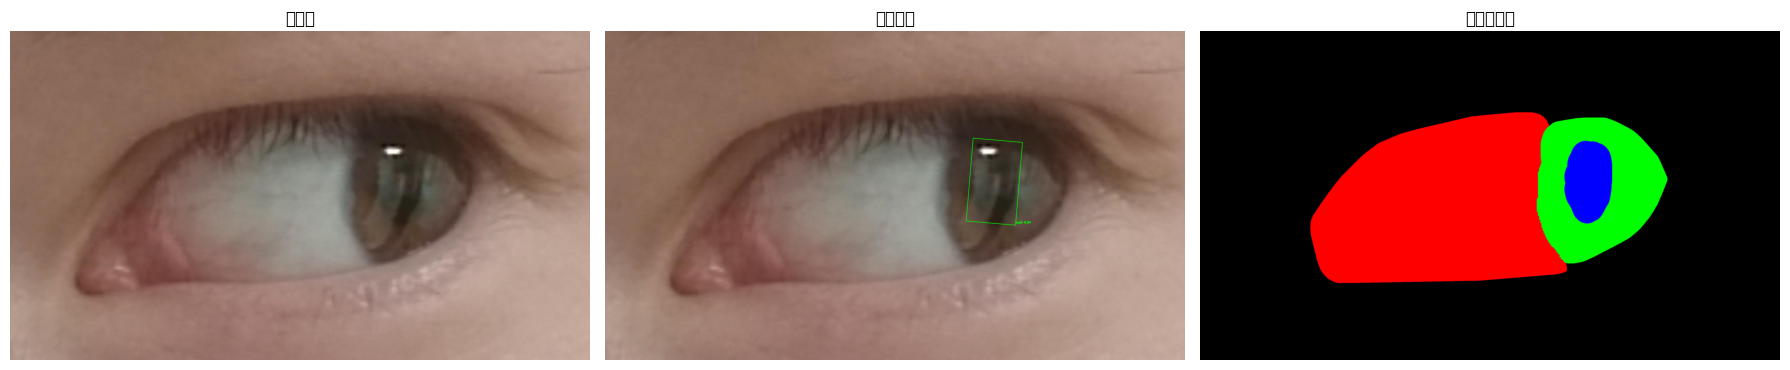

In [5]:
### Mobius (正解のマスクあり)

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# モデルのロード
model = YOLO(r"C:\Users\CorneAI\YOLOv11_OBB\models\yolo11n_obb_pupil_Mobius.pt")  # あなたのカスタムモデルのパスを指定

# 画像パス
image_path = r"C:\Users\CorneAI\YOLOv11_OBB\MOBIUS\Images\5\5_1i_Ll_2.jpg"

# 画像パスからマスクパスを自動生成
image_path_obj = Path(image_path)
mask_path = str(image_path_obj).replace("Images", "Masks").replace(".jpg", ".png")
print(f"画像パス: {image_path}")
print(f"マスクパス: {mask_path}")

# 推論実行
results = model(image_path)

# 結果を可視化するための準備
original_img = cv2.imread(image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
mask_img = cv2.imread(mask_path)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

# 検出結果を描画
result_img = original_img.copy()
for result in results:
    # OBBの取得
    xyxyxyxy = result.obb.xyxyxyxy  # ポリゴン形式（4点）
    
    # クラス名と信頼度の取得
    class_names = [result.names[cls.item()] for cls in result.obb.cls.int()]
    confs = result.obb.conf
    
    # 検出したOBBを画像に描画
    for i, box in enumerate(xyxyxyxy):
        pts = box.cpu().numpy().astype(np.int32)
        # ポリゴンを描画
        cv2.polylines(result_img, [pts], True, (0, 255, 0), 2)
        
        # クラス名と信頼度を表示
        label = f"{class_names[i]} {confs[i]:.2f}"
        cv2.putText(result_img, label, (pts[0][0], pts[0][1] - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# 画像を並べて表示
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('元画像')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('検出結果')
plt.imshow(result_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('正解マスク')
plt.imshow(mask_img)
plt.axis('off')

plt.tight_layout()
plt.show()
